In [15]:
#
# NCFApp
# New Customers Forecast Application
# Programma creato per il forecast dei clienti
# 

import numpy             as np    # libreria per la gestione dei numeri
import pandas            as pd    # libreria per la gestione del file csv
import seaborn           as sb    # libreria per la costruzione di grafici
import matplotlib.pyplot as plt   # libreria ausiliaria per la costruzione di grafici
import Tkinter           as tk    # libreria per l'interfaccia grafica
import PIL                        # libreria per la gestione delle immagini
from statsmodels.tsa.stattools    import acf, pacf, adfuller, arma_order_select_ic
from statsmodels.tsa.seasonal     import seasonal_decompose
from statsmodels.tsa.arima_model  import ARIMA, ARIMAResults
from statsmodels.stats.diagnostic import acorr_ljungbox


# Funzione che ritorna l'ultimo consuntivo caricato
def Lastcons():
    df_mesi = df_sstor.index
    return max(df_mesi)

# Funzione che prepara un grafico e lo salva in una figura
def SimplePlot(SeriePandas=None,LabelofSerie=None):
    plt.plot(SeriePandas,label=LabelofSerie)
    plt.legend()
    return plt.figure()

# Funzione che scrive una stringa nel file di log
def Wlog(stringa=None) :
    file_log.writelines([stringa,'\n'])
    
# apre il file di log
file_log = open('NCFAlog.txt', mode='w')
Wlog('Aperta sessione di programma')

# Carica il dataframe dei dati dal file csv e converte la colonna 'MESE' da stringa a data
df_sstor = pd.read_csv('NCFAdati.csv',sep=',',index_col=0, parse_dates=True, infer_datetime_format=True)
Wlog('Caricato archivio consuntivi')
Wlog('Ultimo consuntivo rilevato :'+str(Lastcons()))

alpha  = 0.05
Wlog('Fissato valore di significatività statistica - alpha = 0,05')

mesi_forecast = 24
Wlog('Fissato periodo proiezione forecast : '+str(mesi_forecast)+' mesi dopo ultimo consuntivo')
index_forecast = pd.date_range(Lastcons(), periods=1+mesi_forecast, freq='M')
index_forecast = index_forecast[1:]

#df_sstor['MESE']=pd.to_datetime(df_sstor['MESE'],format='%Y/%m')

In [17]:
# Funzione che data una serie ne calcola il forecast
# l'argomento è la serie storica originale, 
def Forecast(TMS_orig = None, graphic = False):
    
    def test_stationarity(tms = None) :
        # Dickey - Fuller test
        # H0 : la serie non è stazionaria
        # ritorna il p-value
        dftest = adfuller(tms, autolag='AIC')
        print dftest
        return dftest[1]
        #print dftest
        #print 'Results of Dickey-Fuller Test:'
        #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        #for key,value in dftest[4].items():
        #dfoutput['Critical Value (%s)'%key] = value
        #print dfoutput

    def test_whitenoise(tms = None) :   
        # Test Ljung-box sui residui per verifica White noise
        # (H0 : i residui sono WN)
        testWN = acorr_ljungbox(tms,lags=12)
        return testWN
    
    Wlog('Iniziata procedura di FORECAST per la serie temporale '+TMS_orig.name)
    Wlog('Numero di osservazioni presenti      : '+str(len(TMS_orig)))
    
    #Elimina eventuali spazi vuoti
    TMS_orig = TMS_orig.dropna()
    Wlog('Numero di osservazioni post-cleaning : '+str(len(TMS_orig)))
    
    #La serie viene tagliata ai 4 anni più recenti e ...
    # + 12 mesi per la differenziazione stagionale e ...
    # + 1 mese per la differenziazione de-trend
    if len(TMS_orig)>61 :
        TMS_orig = TMS_orig[-61:]
    elif len(TMS_orig)>49 :
        TMS_orig = TMS_orig[-49:]
    elif len(TMS_orig)>37 :
        TMS_orig = TMS_orig[-37:]
    #else :
    #    raise 0
    Wlog('Numero di osservazioni che verranno prese in considerazione (più recenti) : '+str(len(TMS_orig)))
    
    #Calcola ed espone media mobile e deviazione standard su 12 periodi
    TMS_rolmean = TMS_orig.rolling(window=12,center=False).mean()
    TMS_rolstd  = TMS_orig.rolling(window=12,center=False).std()
        
    plt.plot(TMS_orig, label='Original Data')
    plt.plot(TMS_rolmean, label='Rolling Mean')
    plt.plot(TMS_rolstd, label='Rolling Standard Dev.')
    plt.title('Original series, Rolling Mean and Rolling StDev')
    plt.legend()
    start_graph = plt.figure()
    if graphic : plt.show()
    
    # differenziazione per la stagionalita'
    TMS_diff_seas = TMS_orig - TMS_orig.shift(12) #effetto stagionalita' eliminato
    TMS_effetto_trend = TMS_diff_seas / 12        #effetto trend mensile
    #trend mensile medio sull'ultimo anno
    effetto_trend = np.mean(TMS_effetto_trend[-12:].values)
    
    Wlog('Ricalcolata serie temporale depurata degli effetti stagionali')
    Wlog("Ricalcolata serie temporale depurata dell'effetto trend")
    Wlog('Effetto trend mensile (media degli ultimi 12 mesi)'+str(effetto_trend))
    
    decomposition = seasonal_decompose(TMS_orig,two_sided=False)
    TMS_trend     = decomposition.trend.dropna()
    TMS_seas      = decomposition.seasonal.dropna()
    TMS_resid     = decomposition.resid.dropna()

    plt.subplot(411)
    plt.plot(TMS_orig, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(TMS_trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(TMS_seas,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(TMS_resid, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    decompose_graph = plt.figure()
    if graphic : plt.show()
    
    # Ricerca il numero di differenziazioni sino a giungere alla stazionarietà
    max_diff  = 5
    TMS_for_test = TMS_resid
    rank_diff = 0
    
    Wlog('Test per la verifica della stazionarietà sulla serie destagionalizzata e detrendizzata')
    
    while (test_stationarity(TMS_for_test) > alpha) and (rank_diff < max_diff) :
        rank_diff += 1
        TMS_for_test = TMS_for_test - TMS_for_test.shift()
        TMS_for_test = TMS_for_test.dropna()
    
    Wlog('Numero di differenziazioni da attuare per rendere la serie stazionaria : '+str(rank_diff))
    Wlog('Se uguale a zero   : valore ammissibile ma piuttosto raro')
    Wlog('Se uguale a uno    : valore standard e diffuso')
    Wlog('Se uguale a due    : possono esserci trend anomali (almeno quadratici)')
    Wlog('Se maggiore di due : valori anomali - serie temporale imprevedibile, anche se converge rischio di inferenza distorta')
    
    # se la serie è già stazionaria prova a vedere se si tratta di un white noise
    if rank_diff == 0 :
        if test_whitenoise(TMS_resid) > alpha : 
            whitenoise = True
        else :
            whitenoise = False
    else :
        whitenoise = False
        
    if whitenoise :
        Wlog('Serie temporale uguale al white noise - nessuna ulteriore informazione catturabile')
        TMS_predict = pd.Series(0,index=df_sstor.index)
        TMS_forecast = pd.Series(0,index=index_forecast)
    else :
        # rappresentazione di ACF e PACF
        lag_acf = acf(TMS_for_test, nlags=15)
        lag_pacf = pacf(TMS_for_test, nlags=15, method='ols')
        #Plot ACF: 
        plt.subplot(121) 
        plt.plot(lag_acf)
        plt.axhline(y=0,linestyle='--',color='gray')
        plt.axhline(y=-1.96/np.sqrt(len(TMS_for_test)),linestyle='--',color='gray')
        plt.axhline(y=1.96/np.sqrt(len(TMS_for_test)),linestyle='--',color='gray')
        plt.title('Autocorrelation Function')
        #Plot PACF:
        plt.subplot(122)
        plt.plot(lag_pacf)
        plt.axhline(y=0,linestyle='--',color='gray')
        plt.axhline(y=-1.96/np.sqrt(len(TMS_for_test)),linestyle='--',color='gray')
        plt.axhline(y=1.96/np.sqrt(len(TMS_for_test)),linestyle='--',color='gray')
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
        acfpacf_graph = plt.figure()
        if graphic : plt.show()
    
        autoregressive      = TMS_resid
        autoregressive_diff = TMS_for_test
    
        criteria_ic = arma_order_select_ic(autoregressive_diff)
        rank_AR = criteria_ic.bic_min_order[0]
        rank_MA = criteria_ic.bic_min_order[1]
        Wlog('Modello autoregressivo stimato : ARIMA('+str(rank_AR)+','+str(rank_diff)+','+str(rank_MA)+')')
    
        results_AR = model.fit(disp=-1)
    
        TMS_predict = results_AR.fittedvalues
 
        #print results_AR.summary()
        #plt.plot(autoregressive_diff)
        #plt.plot(TMS_predict, color='red')
        #plt.title('RSS: %.4f'% sum((TMS_predict.dropna()-autoregressive_diff)**2))
        #plt.show()
    
        forecast = results_AR.forecast(steps=mesi_forecast)
        #print forecast
        TMS_forecast    = pd.Series(forecast[0],index=index_forecast)
        forecast_stderr = pd.Series(forecast[1],index=index_forecast)
   
    # FORECAST

    new_TMS_predict = TMS_predict + TMS_trend + TMS_seas

    new_TMS_trend = pd.Series(effetto_trend,index=index_forecast)
    new_TMS_trend[0] = new_TMS_trend[0] + TMS_trend[-1]
    new_TMS_trend = new_TMS_trend.cumsum()
    
    mask_seas = TMS_seas[-12:]
    new_TMS_seas = pd.Series(0,index=index_forecast)
    index_base = 0
    ranges = range(0,len(index_forecast))
    for index_base in ranges :
        index_mask = index_base % 12
        new_TMS_seas[index_base] = mask_seas[index_mask]
    
    # Serie di forecast finale
    
    new_TMS_forecast = TMS_forecast + new_TMS_trend + new_TMS_seas
    
    plt.plot(TMS_orig,        color='blue', label='Valori osservati')
    plt.plot(new_TMS_predict, color='red',  label='Valori predetti')
    plt.plot(new_TMS_forecast,color='green',label='Valori forecast')
    plt.legend(loc='best')
    end_graph = plt.figure()
    if graphic : plt.show()
    
    
    TMS_orig.name ='Original'
    TMS_trend.name='Trend'
    TMS_seas.name ='Seasonality'
    TMS_resid.name='Residuals'
    #print pd.concat([TMS_orig,TMS_trend,TMS_seas,TMS_resid],axis=1)
       #df_fore = pd.DataFrame.from_items([('value',TMS_forecast),('std error',forecast_stderr)])
    #print df_fore

    return start_graph, decompose_graph, end_graph

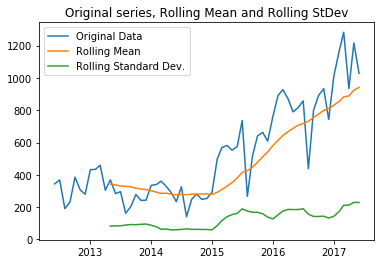

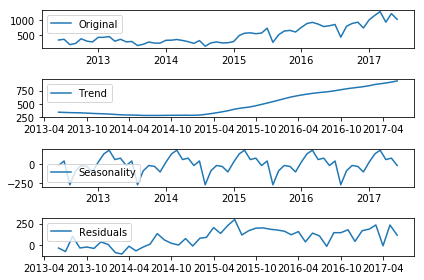

(-1.5248788450591679, 0.5211702052948286, 4, 44, {'5%': -2.9298856611570252, '1%': -3.5885733964124715, '10%': -2.6031845661157025}, 426.74938014885345)
(-6.9179808863459362, 1.1660882557723036e-09, 2, 45, {'5%': -2.9282991495198907, '1%': -3.5848288532235939, '10%': -2.6023438271604937}, 431.68176076049366)


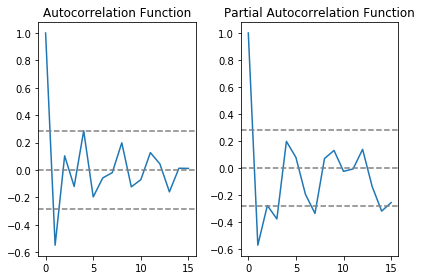

/home/kaidan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kaidan/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:610: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
/home/kaidan/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:612: RuntimeWarning: divide by zero encountered in divide
  invarcoefs = -np.log((1-params)/(1+params))
/home/kaidan/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:652: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/kaidan/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:654: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/kaidan/anaconda2/lib/python2.7/site-packages/statsmo

NameError: global name 'model' is not defined

In [18]:
TimeSerie = pd.Series(df_sstor['FL_IMP'])
a = Forecast(TimeSerie, graphic=True)


In [ ]:
plt.figure = a[1]
plt.figure.show()

In [ ]:
class Application(tk.Frame):
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.grid()
        self.createWidgets()

    def createWidgets(self):
        self.imglogo = PIL.Image.open('Logo.jpg')
        self.imgA = self.imglogo.resize(size=(600,150))
        self.imgB = PIL.ImageTk.PhotoImage(self.imgA)
        self.canvas1 = tk.Canvas(self,width=600,height=150)
        self.canvas1.create_image(300,75,image=self.imgB)
        self.canvas1.grid()
        
        self.label = tk.Label(text = 'Last consuntive '+Lastcons())
        self.label.grid()
        
        self.quitButton = tk.Button(self, text='Quit', background='darkred', command=self.quit)
        self.quitButton.grid()
        
    def quit(self):
        self.destroy()
        return 

app = Application()
app.master.title('New Customers Forecast Application - rel. 1.0 - (C) Gianni Zattoni')
app.mainloop()


In [ ]:
imA = PIL.Image.new(mode='RGB',size=(100,120),color='green')
imA

In [ ]:
imglogo = PIL.Image.open('Logo.jpg')
imB = imglogo
#imB = PIL.ImageTk.PhotoImage(imglogo)
label = tk.Label(image=imB)
label.grid()

In [ ]:
# Frame principale
class Application(tk.Frame):
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.grid()
        self.createWidgets()

    def createWidgets(self):
        
        self.imglogo = PIL.Image.open('Logo.jpg')
        self.imgA = self.imglogo.resize(size=(600,150))
        self.imgB = PIL.ImageTk.PhotoImage(self.imgA)
        self.canvas1 = tk.Canvas(self,width=600,height=150)
        self.canvas1.create_image(300,75,image=self.imgB)
        self.canvas1.grid()
        
        self.label = tk.Label(text = 'Last consuntive '+Lastcons())
        self.label.grid()
        
        self.quitButton = tk.Button(self, text='Quit', command=self.quit)
        self.quitButton.grid()
        
    def quit(self):
        self.destroy()
        return 

app = Application()
app.master.title('New Customers Forecast Application - rel. 1.0 - (C) Gianni Zattoni')
app.mainloop()


In [ ]:
print Lastcons()

In [ ]:
help('PIL.ImageTk')

In [ ]:
# Funzione che prepara un grafico e lo salva in una figura
def SimplePlot(SeriePandas=None,LabelofSerie=None):
    plt.plot(SeriePandas,label=LabelofSerie)
    plt.legend()
    plt.show()
    return plt.figure()

In [ ]:
SimplePlot(df_totbdt['ST_BDT'],'Stock clienti BdT')

In [ ]:
plt.plot(df_totbdt['CP_BDT'],df_totbdt['FL_BDT'])
plt.show()
#plt.gcf().canvas.draw()
fig = plt.figure()

In [ ]:
fig
print fig

In [ ]:
import PIL

In [ ]:
# create the canvas, size in pixels
canvas = tk.Canvas(width=500, height=200, bg='black')

# pack the canvas into a frame/form
canvas.grid() #expand=YES, fill=BOTH)

# load the .gif image file
logo = PIL.Image.open("Logo.jpg")
gif1 = PIL.ImageTk.PhotoImage(logo)

# put gif image on canvas
# pic's upper left corner (NW) on the canvas is at x=50 y=10
canvas.create_image(50, 10, image=gif1, anchor=N)

In [ ]:

# prova di visualizzazione del grafico

#sb.set(style="ticks")
#pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
#pos -= pos[:, 0, np.newaxis]
#step = np.tile(range(5), 20)
#walk = np.repeat(range(20), 5)

# Initialize a grid of plots with an Axes for each walk
#grid = sb.FacetGrid(d_somma, col="walk", hue="walk", col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
#grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
#grid.map(plt.plot, "step", "position", marker="o", ms=4)

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(w_pad=1)



print type(fig)
graphic = tk.Canvas(app)
q = graphic.create_image(x=1, y=1, image=fig) #canvas.get_tk_widget().grid(row=1,column=24)
canvas.draw()


# create the canvas, size in pixels
#canvas = Canvas(width=300, height=200, bg='black')

# pack the canvas into a frame/form
#canvas.pack(expand=YES, fill=BOTH)

# load the .gif image file
#gif1 = PhotoImage(file='small_globe.gif')

# put gif image on canvas
# pic's upper left corner (NW) on the canvas is at x=50 y=10
#canvas.create_image(50, 10, image=gif1, anchor=N

In [ ]:
import 